In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import imageio
import random
import umap

from matplotlib import colors as mcolors

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

from state_of_the_artefact.utilities import kdtree_density

In [3]:
colors = [mcolors.to_hex(c) for c in plt.cm.tab20.colors]

## 8 Agents, 1 Neighbors, 5 Artefacts, 100 Epochs
 run -a 8 -s 5 -n 1 -e 250 with variance instead of the mean

In [4]:
data_path = "../data/output/500_output_2020-07-23T13-12-54.npy"

x = np.load(data_path, allow_pickle=True)

artefact_means = np.array([a[6] for a in x]) # z_means
artefacts = np.array([a[4] for a in x]) # z
agent_ids = np.array([a[1] for a in x])

n_agents = 8
labels = [f"agent_0_{i}" for i in range(0, n_agents)]

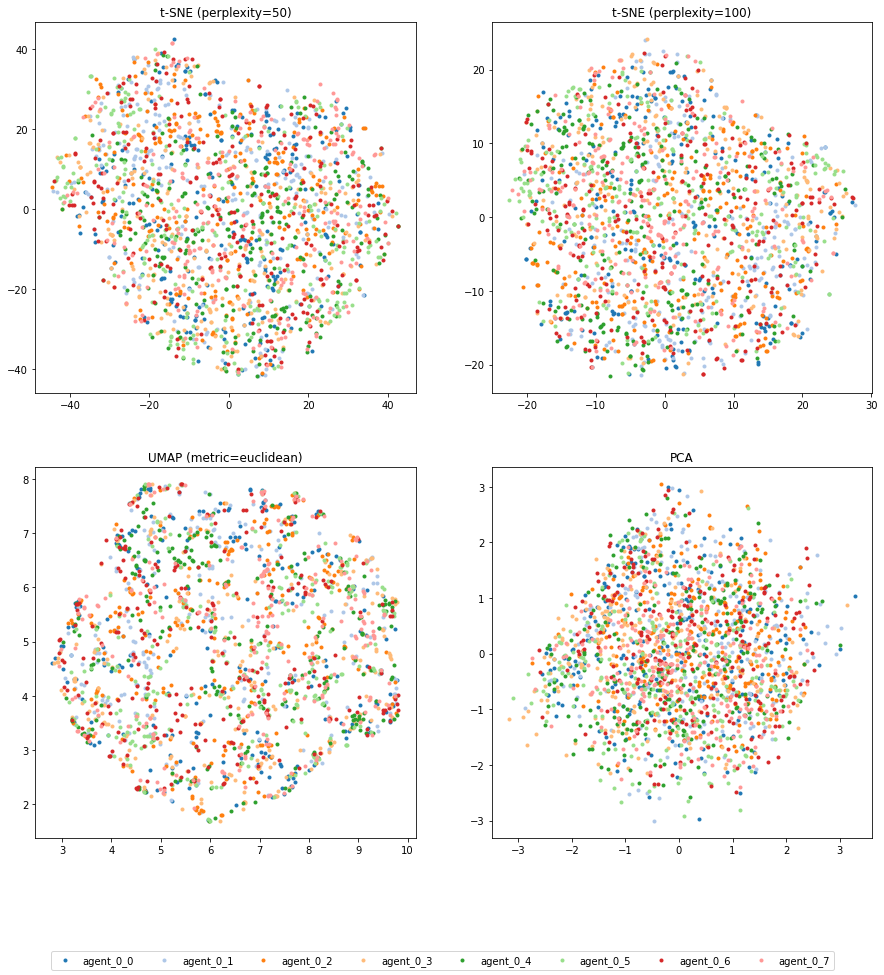

Number of artefacts: 2040


In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

perplexities = [50, 100]

for i, ax in enumerate(axs.flatten()):
    if i < 2:
        tsne = manifold.TSNE(n_components=2, random_state=1, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefact_means)
        ax.set_title(f"t-SNE (perplexity={perplexities[i]})")
    elif i == 2:
        metric = "euclidean"
        
        if metric == "manhattan" or metric == "euclidean":
            umap_artefacts = artefact_means
        
        if metric == "hamming":
            umap_artefacts = artefacts.reshape(artefacts.shape[0], artefacts.shape[1] * artefacts.shape[2])
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.0, metric=metric)
        embedded = reducer.fit_transform(umap_artefacts)
        ax.set_title(f"UMAP (metric={metric})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefact_means)
        ax.set_title("PCA")

    for j, label in enumerate(labels):
        x, y = embedded[j::n_agents, 0], embedded[j::n_agents, 1]
        ax.scatter(x, y, c=colors[j % n_agents], label=label, marker=".")

fig.legend(labels=labels, loc="lower center", ncol=8)
plt.show()
print(f"Number of artefacts: {len(artefacts)}")

Above is a visualization of all artefacts' positions after the final epoch. The colours show the creator of the artefact. At first, I expected cluster to emerge due to social interactions. While agents appear to hang around in a certain spot, they also create artefacts beyond that area. I realize that this expected behaviour as they all belong to the same culture, and therefore have access to inspiration (artefacts) that can are not in their specific "spot". 

With this in mind, I expected that when introducing more cultures and show works created by culture, the clusters would emerge. And if they are allowed to mingle, we might see some overlap emerge.

Number of artefacts: 2040


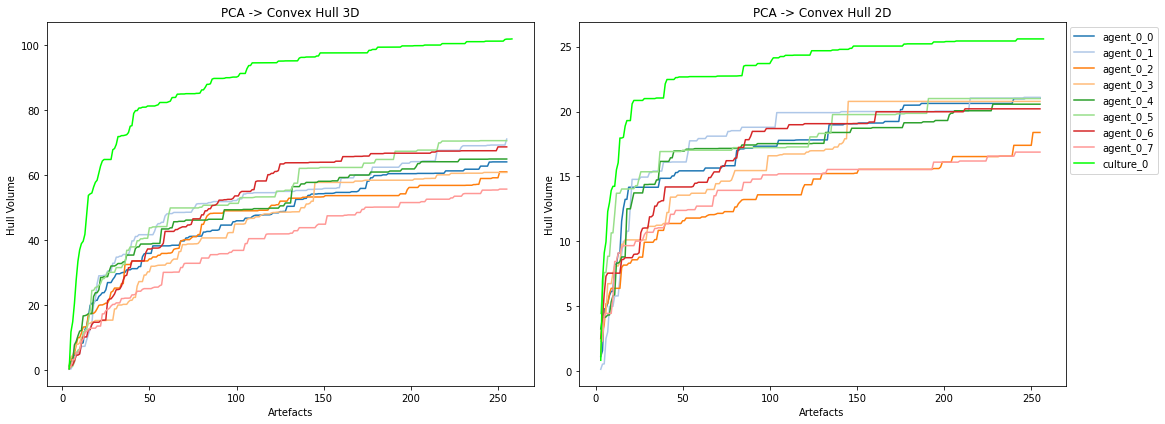

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# -- CONVEX HULLS 3D

pca_3d = decomposition.PCA(n_components=3)
pca_embedded_3d = pca_3d.fit_transform(artefact_means)

agent_hulls_3d = []

for i in range(0, n_agents):
    volumes = []
    embeddded = pca_embedded_3d[i::n_agents]
    
    hull = sp.spatial.ConvexHull(embeddded[:4], incremental=True)
    volumes.append(hull.volume)

    for j in range(4, len(embeddded)):
        hull.add_points([embeddded[j]])
        volumes.append(hull.volume)
    hull.close()
    
    agent_hulls_3d.append(hull)

    ax[0].plot(range(4, len(volumes) + 4), volumes, c=colors[i % n_agents], label=labels[i])


culture_volumes_3d = []

culture_hull_3d = sp.spatial.ConvexHull(pca_embedded_3d[:4], incremental=True)
culture_volumes_3d.append(culture_hull_3d.volume)

for j in range(4, len(artefacts)):
    culture_hull_3d.add_points([pca_embedded_3d[j]])
    culture_volumes_3d.append(culture_hull_3d.volume)
culture_hull_3d.close()

x = range(4, round(len(culture_volumes_3d) / n_agents) + 4)
y = culture_volumes_3d[0::n_agents]

ax[0].plot(x, y, c='lime', label="culture_0")
ax[0].set_title('PCA -> Convex Hull 3D')
ax[0].set_ylabel('Hull Volume')
ax[0].set_xlabel('Artefacts')

# -- CONVEX HULLS 2D

pca_2d = decomposition.PCA(n_components=2)
pca_embedded_2d = pca_2d.fit_transform(artefact_means)

agent_hulls_2d = []

for i in range(0, n_agents):
    volumes = []
    embeddded = pca_embedded_2d[i::n_agents]

    hull = sp.spatial.ConvexHull(embeddded[:3], incremental=True)
    volumes.append(hull.volume)

    for j in range(3, len(embeddded)):
        hull.add_points([embeddded[j]])
        volumes.append(hull.volume)
    hull.close()
    
    agent_hulls_2d.append(hull)

    ax[1].plot(range(3, len(volumes) + 3), volumes, c=colors[i % n_agents], label=labels[i])
 
 
culture_volumes_2d = []

culture_hull_2d = sp.spatial.ConvexHull(pca_embedded_2d[:3], incremental=True)
culture_volumes_2d.append(culture_hull_2d.volume)

for j in range(3, len(artefacts)):
    culture_hull_2d.add_points([pca_embedded_2d[j]])
    culture_volumes_2d.append(culture_hull_2d.volume)
culture_hull_2d.close()

x = range(3, round(len(culture_volumes_2d) / n_agents) + 3)
y = culture_volumes_2d[0::n_agents]

ax[1].plot(x, y, c='lime', label="culture_0")
ax[1].set_title('PCA -> Convex Hull 2D')
ax[1].set_ylabel('Hull Volume')
ax[1].set_xlabel('Artefacts')


plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

The area or volume covered is consistently rising as the agents explore more of the conceptual space. Long runs for the simulation are needed to see where it levels out. This could indicate that there are very little extra things to explore, as the agents are generating artefacts within the current limits of the spaces. I'm not 100% sure if this is a correct assertion, but that would mean that they work within the rules they have currently established. 

If it keeps expanding, it might mean that artefacts move to far away from their original locations, and keep doing so. They are continuously transforming the conceptual space. The infinite expansion would be against my hypothesis, as this would eliminate the need for transformation via culture-to-culture interactions.

### 3D Projection of the Convex Hull, and their center points.

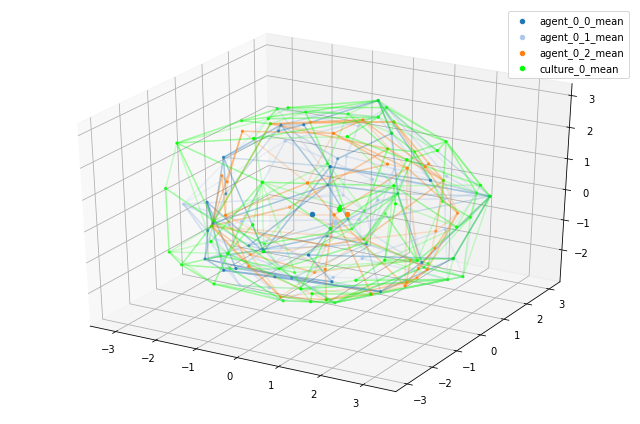

In [7]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

# -- AGENTS

# -- for now only project 3 agents, if all 8, it becomes very messy
for i, hull in enumerate(agent_hulls_3d[:3]):
    points = hull.points

    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], c=colors[i % n_agents], alpha=.2)
    
    vertices = np.array([[points[vertex, 0], points[vertex, 1], points[vertex, 2]] for vertex in hull.vertices])
    
    # every vertex is an artefact
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=colors[i % n_agents], marker=".")

    # the large dot in the centers is the mean
    mean = vertices.mean(axis=0)
    ax.scatter(mean[0], mean[1], mean[2], c=colors[i % n_agents], label=labels[i] + "_mean")

# -- CULTURE

points = culture_hull_3d.points

for simplex in culture_hull_3d.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], c="lime", alpha=.2)

vertices = np.array([[points[vertex, 0], points[vertex, 1], points[vertex, 2]] for vertex in culture_hull_3d.vertices])
    
# every vertex is an artefact
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c="lime", marker=".")

# the large dot in the centers is the mean
mean = vertices.mean(axis=0)
ax.scatter(mean[0], mean[1], mean[2], c="lime", label="culture_0_mean")


plt.tight_layout()
plt.legend()
plt.show()

### 2D Projection of the Convex Hull, and their center points.

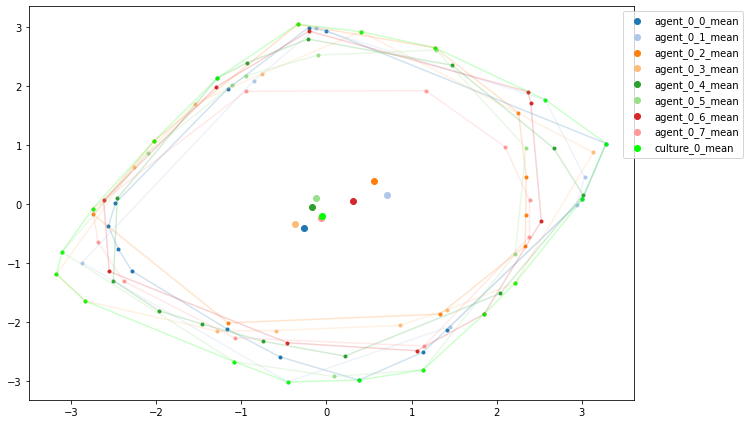

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# -- AGENTS

for i, hull in enumerate(agent_hulls_2d):
    points = hull.points

    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], c=colors[i % n_agents], alpha=.2)
    
    vertices = np.array([[points[vertex, 0], points[vertex, 1]] for vertex in hull.vertices])
    
    # every vertex is an artefact
    ax.scatter(vertices[:, 0], vertices[:, 1], c=colors[i % n_agents], marker=".")

    # the large dot in the centers is the mean
    mean = vertices.mean(axis=0)
    ax.scatter(mean[0], mean[1], c=colors[i % n_agents], label=labels[i] + "_mean")

# -- CULTURE

points = culture_hull_2d.points

for simplex in culture_hull_2d.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], c="lime", alpha=.2)

vertices = np.array([[points[vertex, 0], points[vertex, 1]] for vertex in culture_hull_2d.vertices])    

# every vertex is an artefact
ax.scatter(vertices[:, 0], vertices[:, 1], c="lime", marker=".")

# the large dot in the centers is the mean
mean = vertices.mean(axis=0)
ax.scatter(mean[0], mean[1], c="lime", label="culture_0_mean")


plt.tight_layout()
plt.legend(loc="upper right", bbox_to_anchor=(1.19, 1))
plt.show()

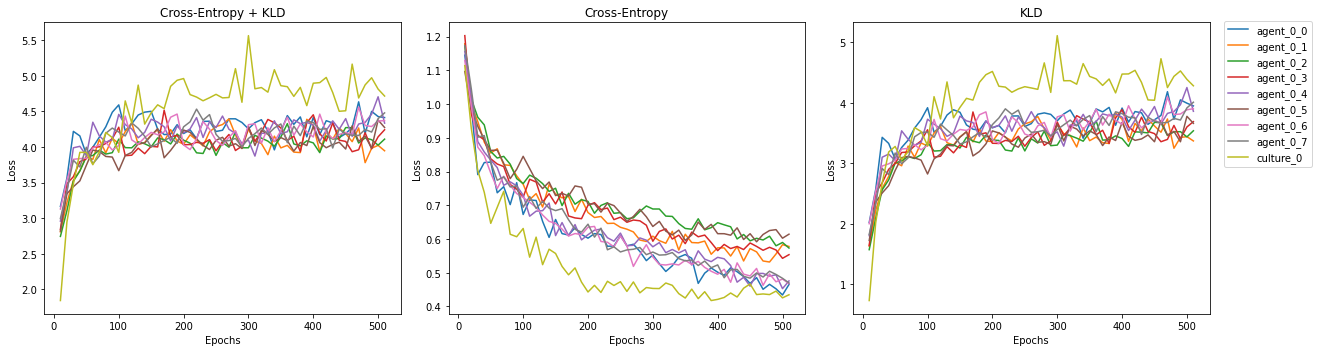

In [11]:
data_eval_path = "../data/output/500_output_2020-07-23T13-12-54_evaluations.npy"
evaluations = np.load(data_eval_path, allow_pickle=True)
evaluations = np.array([e for e in evaluations if len(e) > 0])

labels_eval = [f"agent_0_{i}" for i in range(n_agents)] + ["culture_0"] 
fig_4, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, label in enumerate(labels_eval):
    loss = np.array([epoch[i][0] for epoch in evaluations])
    CE = np.array([epoch[i][1] for epoch in evaluations])
    KL = np.array([epoch[i][3] for epoch in evaluations])
    
    axs[0].plot(range(10, (evaluations.shape[0] + 1) * 10, 10), loss, label=label)
    axs[1].plot(range(10, (evaluations.shape[0] + 1) * 10, 10), CE, label=label)
    axs[2].plot(range(10, (evaluations.shape[0] + 1) * 10, 10), KL, label=label)

axs[0].set_title('Cross-Entropy + KLD')
axs[1].set_title('Cross-Entropy')
axs[2].set_title('KLD')

for ax in axs:
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')

plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.022))
plt.show()

Above the performance of the RVAE's during the simulation is shown. The cross-entropy loss is still improving even on the limited samples provided during the simulation, but the KL divergence is increasing. This suggests that with every epoch, the model needs to work harder to maintain the distributions of the latent variables. The cross-entropy loss shows that the model is still learning. Still, I'm suspicious that the high KL term leads to the model ignoring the distributions, and it effectively becomes a regular autoencoder.

One way I can think of to remedy this is to do longer pretraining sessions. This should reduce the amount of learning needed during the simulation, but should still model the behaviours that are of interest.


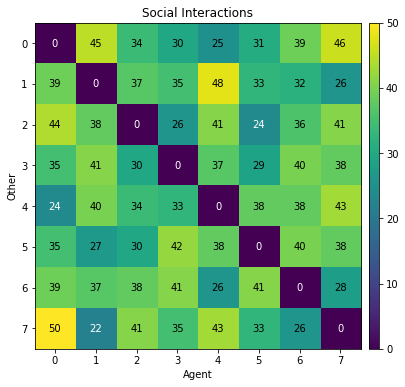

In [13]:
from state_of_the_artefact.helpers.plottools import plot_confusion_matrix

interactions = np.load("../data/output/500_output_2020-07-23T13-12-54_interactions.npy", allow_pickle=True)
cm = np.zeros((n_agents, n_agents), dtype='int')

for x in range(n_agents):
    neighbours = np.array([n[2] for n in interactions if n[1] == x])
    unique, counts = np.unique(neighbours.flatten(), return_counts=True)

    for i, y in enumerate(unique):
        cm[x, y] = counts[i]

n_interactions = interactions.shape[0] // n_agents
assert np.all(np.sum(cm, axis=1) == n_interactions), "The number of interactions of every agent is incorrect"

plot_confusion_matrix(cm, np.arange(0, n_agents + 1), 'Social Interactions', 'Agent', 'Other', cmap="viridis", colorbar=True, annotate=True)
plt.show()

This shows what agents interaction with whom. Next step here is to combine this with the plots below, to see attraction and repulsion behaviours.


In [14]:
reconstructions = np.load("../data/output/500_output_2020-07-23T13-12-54_reconstructions.npy", allow_pickle=True)
reconstructions = reconstructions.reshape(1)[0]
reconstructions.keys()

dict_keys(['cultures', 'agents'])

In [63]:
np.array([0]).shape

(48, 5)

In [19]:
r_cultures = reconstructions['cultures']
artefact_ids = [r[0] for r in r_cultures[0]]

# z_means_xvZDZUbR = []
# z_means_kvZHylRnR = []
# z_means_xYZHQPRbh = []

# colors = ["r", "g", "b",]
colors = [mcolors.to_hex(c) for c in plt.cm.tab20.colors]

every_n_epochs = 5
show_n_artefacts = 20
epochs = 250 / every_n_epochs + 1

z_means = [[] for _ in range(show_n_artefacts)]
first_artefact_norms = []
all_artefact_norms = []

for e in range(len(r_cultures)):
    # -- calculate distances between original position and current position
    first_artefact_norms.append([np.linalg.norm(r[1] - r[2]) for r in r_cultures[e] if r[0] in artefact_ids])
    all_artefact_norms.append([np.linalg.norm(r[1] - r[2]) for r in r_cultures[e]])

    # -- filter artefacts for visualization
    for i, artefact_id in enumerate(artefact_ids[:show_n_artefacts]):
        z_means[i] += [r[2] for r in r_cultures[e] if r[0] == artefact_id]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].boxplot(first_artefact_norms)
axs[0].set_title('Distances from original to current latent positions.\n (only artefacts that exist in every epoch are included)')
axs[0].set_xticklabels(np.arange(0, epochs * show_n_artefacts, 5))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('distance')

axs[1].boxplot(all_artefact_norms)
axs[1].set_title('Distances from original to current latent positions.\n (all artefacts that exist in every epoch are included)')
axs[1].set_xticklabels(np.arange(0, epochs * show_n_artefacts, 5))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('distance')

pca_2d = decomposition.PCA(n_components=2)
embedded = pca_2d.fit_transform(np.array(z_means).reshape(epochs * show_n_artefacts, 32))

markers = ['s', *['.' for _ in range(0, epochs - 2)], 'o']

fig2, axs2 = plt.subplots(1, 1, figsize=(14.4, 14.4))
a = 0
for i, (x, y) in enumerate(embedded):
    if i >= (a + 1) * epochs:
        a += 1
    axs2.scatter(x, y, marker=markers[i % epochs], c=colors[a], alpha=.5)

for i, embedded in enumerate(embedded.reshape(show_n_artefacts, epochs, 2)):
    axs2.plot(embedded[:,0], embedded[:,1], c=colors[i], alpha=.5)

axs2.set_ylim(-5, 5)
axs2.set_xlim(-5, 5)

plt.show()

TypeError: 'float' object cannot be interpreted as an integer

Above we see how the artefacts are positions after every fifth epoch. Some artefacts stay more or less in place while others do a random walk. These are just a small selection of artefacts that change positions over time after agents learn new fuzzy relations from the presented artefacts each epoch.

The next step is to show how agents move positions and after interaction with which agent. Combined with the confusion matrix above, it could show attraction and repulsion behaviours.

The boxplots show the distances variances between the original position of the artefact and the position for the respective epoch. These distances are calculated over 32d space, and therefore the distances are slightly larger. The plot uses distances after using PCA to reduce the 32d space down to two. The outliers are a bit odd, and I'm planning to look a bit more into this, if relevant for the final experiments. But overall, the variation is quite stable for the artefacts that exist from the beginning. The second boxplot needs another check to see if everything is calculated correctly as new artefacts are introduced every epoch.